In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import git
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [38]:
df = pd.read_csv(f"{homedir}/LTH_predictions.csv")

In [39]:
df.head()

,id,10,20,30,40,50,60,70,80,90
0,2020-04-01-10001,0.0,0.00,0.00,0.00,0.00,0.10,0.28,0.47,0.74
1,2020-04-01-10003,0.0,0.03,0.38,0.67,0.93,1.24,1.45,1.79,2.29
2,2020-04-01-10005,0.0,0.21,0.56,0.74,0.89,1.00,1.12,1.31,1.70
3,2020-04-01-1001,0.0,0.00,0.00,0.00,0.03,0.15,0.28,0.49,0.73
4,2020-04-01-1003,0.0,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01


In [40]:
import datetime as dt

# string to datetime object conversion
def date_from_str(ds):
    year = int(ds[:4])
    month = int(ds[5:7])
    day = int(ds[8:])
    return dt.datetime(year, month, day)

# datetime object to string conversion
def str_from_date(date):
    return date.strftime("%Y-%m-%d")

# returns date that is N weeks prior to date
def weeks_prior_date(date, N):
    return (date - dt.timedelta(weeks=N))

In [41]:
d1 = []
d2 = []
d3 = []
d4 = []
d5 = []

In [46]:
import pandas as pd 
import numpy as np
import sys
import traceback
from tqdm.auto import tqdm

csv_to_score = f"{homedir}/LTH_predictions.csv"

def get_date(x):
    return '-'.join(x.split('-')[:3])
def get_fips(x):
    return x.split('-')[-1]
def pinball_loss(y_true, y_pred, quantile = 0.5):
    delta = y_true - y_pred
    loss_above = np.sum(delta[delta > 0])*(quantile)
    loss_below = np.sum(-1*delta[delta < 0])*(1-quantile)
    return (loss_above + loss_below) / len(y_true)
def evaluate(test_df, user_df):
    join_df = test_df.join(user_df, how = 'inner')
    if(len(join_df) != len(test_df)):
        sys.stderr.write("Submission not right length. \n")
        raise Exception("Submission not right length")
    if(user_df.isna().sum().sum() > 0 ):
        sys.stderr.write("Submission contains NaN. \n")
        raise Exception("Submission Contains NaN.")
    if(join_df.index.equals(test_df.index) == False):
        sys.stderr.write("Incorrect ID format in Submission. \n")
        raise Exception("Incorrect ID format.")
    total_loss = 0
    for column in ['10','20','30','40','50', '60', '70', '80', '90']:
        quantile = int(column) / 100.0
        total_loss += pinball_loss(join_df['deaths'].values, join_df[column].values, quantile) / 9.0
    return total_loss

daily_df = pd.read_csv(f'{homedir}/data/us/covid/nyt_us_counties_daily.csv')
daily_df['fips'] = daily_df['fips'].astype(int)
daily_df['id'] = daily_df['date'] +'-'+ daily_df['fips'].astype(str)
counties = set(list(daily_df[(daily_df['deaths'] >= 20) & (daily_df['date'] == '2020-05-01')]['fips']))

loss = [] # index will be days since the start date

currd = date_from_str('2020-05-10')
endd = date_from_str(daily_df['date'].max())
while currd <= endd:
    start_date = str_from_date(currd)
    end_date = start_date
    currd = currd + dt.timedelta(days=1)
    
    preperiod_df = daily_df[(daily_df['date'] < start_date)]
    daily_df = daily_df[(daily_df['date'] <= end_date)  & (daily_df['date'] >= start_date)]

    sample_submission = pd.read_csv(f'{homedir}/sample_submission.csv') # Load the sample submission with all 0's
    sample_submission['date'] = sample_submission['id'].apply(get_date)
    sample_submission['fips'] = sample_submission['id'].apply(get_fips).astype('int')
    sample_submission = sample_submission[(sample_submission['date'] <= end_date)  & (sample_submission['date'] >= start_date)]

    # Disabled FIPS is a set of FIPS to avoid scoring. Covid_active_fips is where there has been reports of covid, 
    # and inactive_fips are fips codes present in sample submission but with no cases reported by the New York Times.
    # New_active_fips are FIPS that were introduced into the dataset during the scoring period. 
    # Active FIPS should be scored against deaths data from NYT if such data is available, 
    # but Inactive FIPS should be scored with a target of 0.
    d_fips = set({
        ## NEW YORK
        36005, 36047, 36081, 36085, 
        ## Peurto Rico
        72001, 72003, 72005, 72007, 72009, 72011, 72013, 72015, 72017,
        72019, 72021, 72023, 72025, 72027, 72029, 72031, 72033, 72035,
        72037, 72039, 72041, 72043, 72045, 72047, 72049, 72051, 72053,
        72054, 72055, 72057, 72059, 72061, 72063, 72065, 72067, 72069,
        72071, 72073, 72075, 72077, 72079, 72081, 72083, 72085, 72087,
        72089, 72091, 72093, 72095, 72097, 72099, 72101, 72103, 72105,
        72107, 72109, 72111, 72113, 72115, 72117, 72119, 72121, 72123,
        72125, 72127, 72129, 72131, 72133, 72135, 72137, 72139, 72141,
        72143, 72145, 72147, 72149, 72151, 72153,
        ## Virgin Islands
        78010, 78020, 78030
    })
    disabled_fips = set(list(sample_submission['fips']))
    disabled_fips = disabled_fips - (counties - d_fips)
    prev_active_fips = set(preperiod_df.fips.unique())
    curr_active_fips = set(daily_df.fips.unique())
    all_fips = set(sample_submission.fips.unique())
    covid_active_fips = prev_active_fips.intersection(all_fips).intersection(curr_active_fips) - disabled_fips
    inactive_fips = all_fips - prev_active_fips - curr_active_fips - disabled_fips
    new_active_fips = (curr_active_fips - prev_active_fips).intersection(all_fips) - disabled_fips

    # Create a DataFrame of all 0's for inactive fips by getting those from sample submission.
    inactive_df = sample_submission.set_index('fips')[['id','50']].loc[inactive_fips]
    inactive_df = inactive_df.set_index('id').rename({'50':'deaths'}, axis = 1)
    assert(inactive_df.sum().sum() == 0)
    # Create a DataFrame of active fips from the New York Times data
    active_df = daily_df.set_index('fips')[['id', 'deaths']].loc[covid_active_fips].set_index('id')

    # Create dataframe for new fips
    sample_search = sample_submission.set_index('fips')[['id','50']].rename({'50':'deaths'}, axis = 1)
    daily_search = daily_df.set_index('fips')
    new_df_arr = []
    for fips in new_active_fips:
        tmp_sample = sample_search.loc[[fips]].set_index('id')
        tmp_daily = daily_search.loc[[fips]].set_index('id')
        tmp_sample.update(tmp_daily)
        tmp_sample = tmp_sample[tmp_sample.index <= tmp_daily.index.max()]
        new_df_arr.append(tmp_sample)

    # Join the data frames
    example = None
    if(len(new_active_fips) > 0):
        new_df = pd.concat(new_df_arr)
        example = pd.concat([inactive_df, active_df, new_df]).sort_index()
    else:
        example = pd.concat([inactive_df, active_df]).sort_index()
    # Read some CSV for score
    df = pd.read_csv(csv_to_score).set_index('id').sort_index()
    score = evaluate(example[['deaths']], df)
    d5.append(score)
    print('Got score of {:.6f}'.format(score))

Got score of 4.404196


/Users/ethaneason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Got score of nan
Got score of 3.284677
Got score of 3.324757
Got score of 3.185894
Got score of 3.166450
Got score of 3.097101
Got score of 2.925958
Got score of 2.573497
Got score of 2.363228
Got score of 2.304693
Got score of 2.202519
Got score of 2.036175
Got score of 1.882656
Got score of 1.954614
Got score of 1.840614
Got score of 1.637000
Got score of 1.622989
Got score of 1.489709
Got score of 1.600772
Got score of 1.528190
Got score of 1.399720
Got score of 1.435286
Got score of 1.375534
Got score of 1.377164


Text(0.5, 1.0, "Pinball Loss for each Day's Prediction since May 10th")

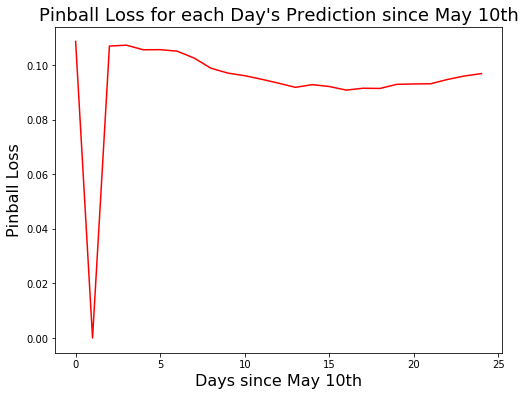

In [22]:
plt.figure(figsize=(8,6))
plt.plot(loss, color='red')
plt.xlabel("Days since May 10th", fontsize=16)
plt.ylabel("Pinball Loss", fontsize=16)
plt.title("Pinball Loss for each Day's Prediction since May 10th", fontsize=18)

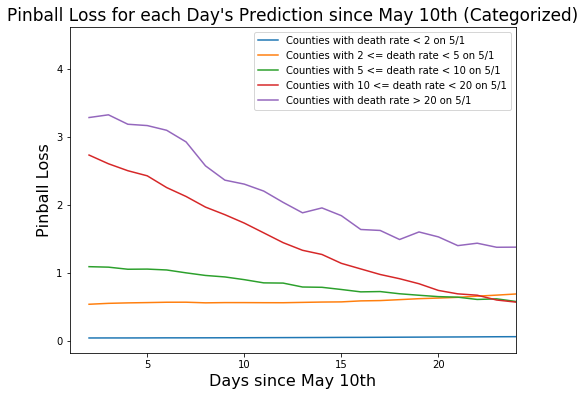

In [53]:
plt.figure(figsize=(8,6))
plt.plot(d1)
plt.plot(d2)
plt.plot(d3)
plt.plot(d4)
plt.plot(d5)
plt.xlim((1,24))
plt.xlabel("Days since May 10th", fontsize=16)
plt.ylabel("Pinball Loss", fontsize=16)
plt.title("Pinball Loss for each Day's Prediction since May 10th (Categorized)", fontsize=17)
plt.legend(['Counties with death rate < 2 on 5/1', 'Counties with 2 <= death rate < 5 on 5/1', 
            'Counties with 5 <= death rate < 10 on 5/1', 'Counties with 10 <= death rate < 20 on 5/1',
            'Counties with death rate > 20 on 5/1'])